In [1]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from time import time
import os


# %matplotlib inline
# %load_ext autoreload
# %autoreload 

In [2]:
def return_data(fold,month,with_scaling, station_id = None):
    train_input = pd.read_csv('AAAI22/data/processed'+'/fold_'+str(fold)+'_train_'+month+'.csv.gz')
    test_input = pd.read_csv('AAAI22/data/processed'+'/fold_'+str(fold)+'_test_'+month+'.csv.gz')
    if station_id != None:
        test_input = test_input[test_input['station_id'] == station_id]
    test_output = np.concatenate((np.array(test_input['PM25_Concentration']).reshape(-1,1), np.array(test_input['CO_Concentration']).reshape(-1,1)), axis=1)
    train_output = np.concatenate((np.array(train_input['PM25_Concentration']).reshape(-1,1), np.array(train_input['CO_Concentration']).reshape(-1,1)), axis=1)
    train_input= train_input.drop(['station_id','PM25_Concentration','CO_Concentration','time','filled'],axis=1)
    try:
        test_input= test_input.drop(['PM25_Concentration','CO_Concentration','station_id','time','filled'],axis=1)
    except:
        test_input= test_input.drop(['station_id','time','filled'],axis=1)
    if with_scaling:
        scaler_x = MinMaxScaler()
        scaler_y = StandardScaler()
        scaler_y1 = StandardScaler()
        # scaler = MinMaxScaler().fit(train_input)
        # train_input = pd.DataFrame(scaler_x.fit_transform(train_input),columns=list(train_input.columns))
        # train_output = scaler_y.fit_transform(train_output)
        # test_input = pd.DataFrame(scaler_x.transform(test_input),columns=list(test_input.columns))
        # scaler = MinMaxScaler().fit(train_input)
        train_input = torch.tensor(scaler_x.fit_transform(train_input)).to(torch.float32)
        test_input = torch.tensor(scaler_x.transform(test_input)).to(torch.float32)
        train_output[:,0] = torch.tensor(scaler_y.fit_transform(train_output[:,0].reshape(-1,1)).reshape(-1,)).to(torch.float32)
        # print(train_output.shape)
        train_output[:,1] = torch.tensor(scaler_y1.fit_transform(train_output[:,1].reshape(-1,1)).reshape(-1,)).to(torch.float32)
        # print(train_output.shape)
        test_output = torch.tensor(test_output[:,1]).to(torch.float32)
    return train_input, torch.tensor(train_output[:,1]).reshape(-1,).to(torch.float32),test_input,test_output, scaler_y, scaler_y1

In [3]:
for fold in [0]:
    train_input,train_output,test_input,test_output,scaler_pm, scaler_co = return_data(fold=fold,month='mar',with_scaling=True)
    print("Fold: ",fold)
    print("Data received")

Fold:  0
Data received


In [4]:
train_input.shape,train_output.shape,test_input.shape,test_output.shape, train_input.type(), train_output.type()

(torch.Size([166440, 5]),
 torch.Size([166440]),
 torch.Size([87600, 5]),
 torch.Size([87600]),
 'torch.FloatTensor',
 'torch.FloatTensor')

In [5]:
train_x, train_y = train_input, train_output

In [6]:
from skgpytorch.models import SVGPRegressor, SGPRegressor, ExactGPRegressor

In [7]:
from gpytorch.kernels import (
    RBFKernel,
    ScaleKernel,
    PeriodicKernel,
    MaternKernel,
    CosineKernel,
)

In [8]:
def GP_model(train, test):
    train_points = 20000
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_input.shape[1]))
    inducing_points = train_input[np.arange(0, train_points, 1000)]
    model = SGPRegressor(
        train_input[:train_points,:].to("cuda"), train_output[:train_points].to("cuda"), kernel, inducing_points
    ).to("cuda")

    # model =  ExactGPRegressor(
    #     train_input[:train_points,:].to("cuda"), train_output[:train_points].to("cuda"), kernel,
    # ).to("cuda")

    if train:
        loss = model.fit(lr=1e-3, n_epochs=1500, verbose=1, random_state=0)
        #plt.plot(np.asarray(loss[0]))

        # Save model
        model_name = "fullAq_sgpr.pt"
        torch.save(model.state_dict(), os.path.join("models", model_name))
    if test:
        model_name = "Point_to_point_main_power.pt"
        model.load_state_dict(torch.load(os.path.join("./models", model_name)))
    return model

In [9]:
model = GP_model(train=True, test=False)

tensor(1.0989, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 1, iter: 1, loss: 1.0989
tensor(1.0972, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 2, iter: 1, loss: 1.0972
tensor(1.0963, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 3, iter: 1, loss: 1.0963
tensor(1.0958, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 4, iter: 1, loss: 1.0958
tensor(1.0953, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 5, iter: 1, loss: 1.0953
tensor(1.0949, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 6, iter: 1, loss: 1.0949
tensor(1.0945, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 7, iter: 1, loss: 1.0945
tensor(1.0942, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 8, iter: 1, loss: 1.0942
tensor(1.0939, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 9, iter: 1, loss: 1.0939
tensor(1.0937, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 10, iter: 1, loss: 1.0937

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


tensor(1.0925, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 16, iter: 1, loss: 1.0925
tensor(1.0923, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 17, iter: 1, loss: 1.0923
tensor(1.0921, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 18, iter: 1, loss: 1.0921
tensor(1.0919, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 19, iter: 1, loss: 1.0919
tensor(1.0917, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 20, iter: 1, loss: 1.0917
tensor(1.0915, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 21, iter: 1, loss: 1.0915
tensor(1.0914, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 22, iter: 1, loss: 1.0914
tensor(1.0912, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 23, iter: 1, loss: 1.0912
tensor(1.0910, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 24, iter: 1, loss: 1.0910
tensor(1.0909, device='cuda:0', grad_fn=<NegBackward0>)
restart: 0, epoch: 25, iter: 1, los

In [22]:
pred_dist = model.predict((test_input[:10000,:]).to("cuda"))
y_mean = pred_dist.loc
y_mean = scaler_co.inverse_transform(y_mean.reshape(-1, 1).cpu()).squeeze()

print(test_output.shape, y_mean.shape)
y_mean = np.clip(y_mean, 0, y_mean.max(), out=y_mean)
var_pred = pred_dist.variance
var_pred = scaler_pm.inverse_transform(var_pred.reshape(-1, 1).detach().cpu()).squeeze()
std_pred = pred_dist.stddev
# std_pred = torch.tensor(
#     scaler_y.inverse_transform(std_pred.reshape(-1, 1).detach().cpu()).squeeze()
# )

torch.Size([87600]) (10000,)


In [23]:
std_pred

tensor([0.6872, 0.6868, 0.6866,  ..., 0.6887, 0.6888, 0.6886], device='cuda:0',
       grad_fn=<SqrtBackward0>)

In [24]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(y_mean) - test_output[:10000]))))

Test MAE: 0.5117289482234981


In [25]:
std_pred = np.array(std_pred.detach().cpu())/scaler_co.var_

In [26]:
scaler_co.mean_, scaler_co.var_

(array([1.12450539]), array([1.15354243]))

(10000,) (10000,)
0


Text(0.5, 1.0, 'SOGP')

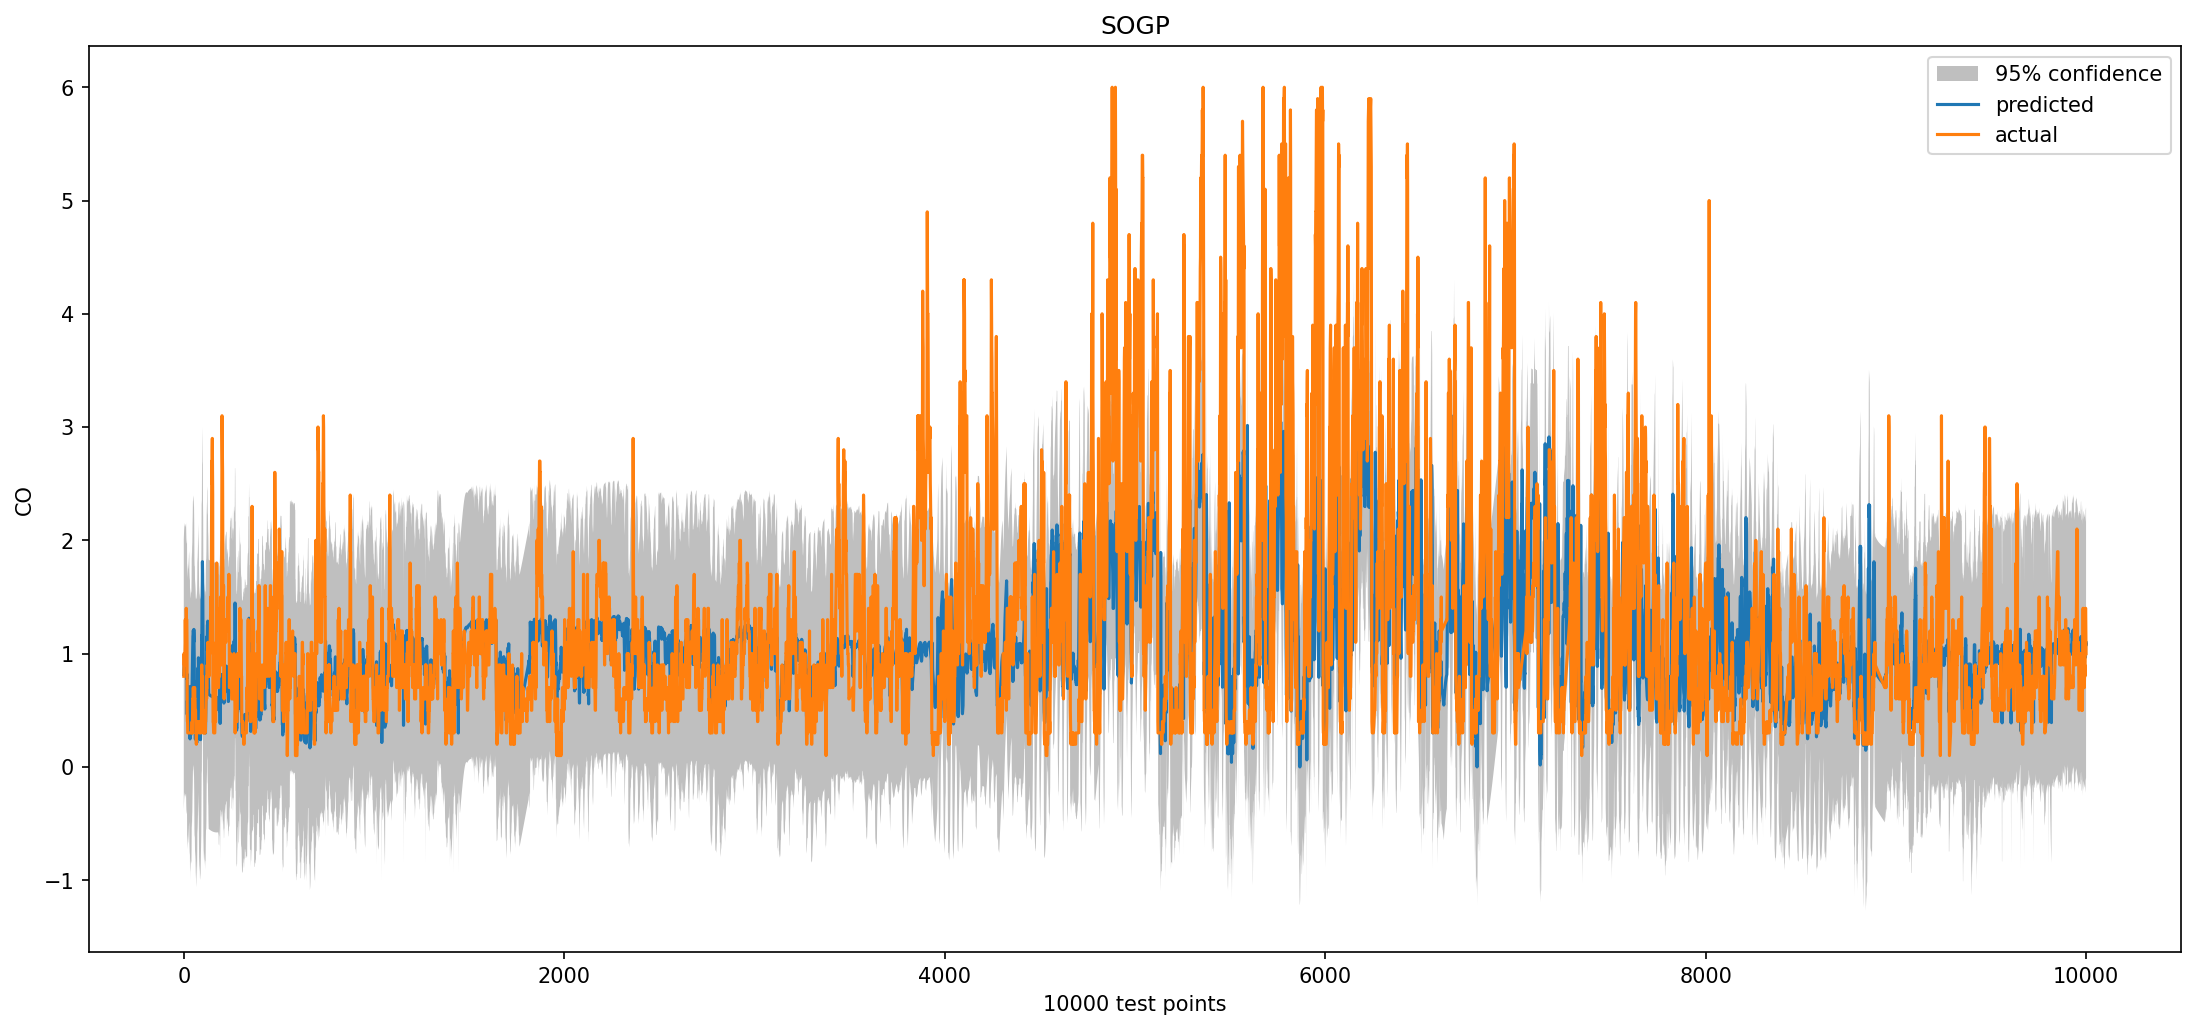

In [27]:
preds_stds = np.array(std_pred)
preds_mean = np.array(y_mean)
lower_line = preds_mean - 2 * preds_stds
upper_line = preds_mean + 2 * preds_stds

test_points = 10000

test_y1 = np.array(test_output)
print(preds_mean.shape, preds_stds.shape)

plt.rcParams["figure.dpi"] = 150
fig = plt.figure(figsize=(18, 8))
plt.fill_between(
    range(len(test_y1[:test_points])),
    lower_line[:],
    upper_line[:],
    facecolor="gray",
    alpha=0.5,
    label=r"95% confidence",
)
print(0)
plt.plot(preds_mean[:], label=r"predicted", linewidth=1.5)
# y_test = test_y1[:5000,:]
plt.plot(test_y1[:test_points], label=r"actual", linewidth=1.5)
plt.ylabel("CO")
plt.legend()
plt.xlabel("10000 test points")
plt.title(
    "SOGP"
)
# plt.savefig(f"deep_variational_station_1006_{i}.png")
# model.train()

# %

In [16]:
# from gpytorch.means import ConstantMean
# from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
# from gpytorch.distributions import MultivariateNormal

# class GPRegressionModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean()
#         self.base_covar_module = ScaleKernel(RBFKernel())
#         self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:50, :].to("cuda:0"), likelihood=likelihood)

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

In [17]:
# likelihood = gpytorch.likelihoods.GaussianLikelihood().to("cuda:0")
# model = GPRegressionModel(train_x[:20000,:].to("cuda:0"), train_y[:20000].to("cuda:0"), likelihood).to("cuda:0")


In [18]:
# training_iterations = 300

# # Find optimal model hyperparameters
# model.train()
# likelihood.train()

# # Use the adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# def train():
#     for i in range(training_iterations):
#         # Zero backprop gradients
#         optimizer.zero_grad()
#         # Get output from model
#         output = model(train_x[:20000,:].to("cuda:0"))
#         # Calc loss and backprop derivatives
#         loss = -mll(output, train_y[:20000].to("cuda:0"))
#         loss.backward()
#         print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
#         optimizer.step()
#         torch.cuda.empty_cache()

# # See dkl_mnist.ipynb for explanation of this flag
# %time train()

In [19]:
# model.eval()
# likelihood.eval()
# with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
#     preds = model(test_input[:10000,:].to("cuda:0"))

In [20]:
# print('Test MAE: {}'.format(torch.mean(torch.abs(scaler_y.inverse_transform(preds.mean.cpu()) - test_output[:10000,0]))))

## RF

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
train_points = 20000

modelRF = RandomForestRegressor()
modelRF.fit(train_input[:train_points,:], train_output[:train_points])

RandomForestRegressor()

In [30]:
pred_rf = modelRF.predict(test_input[:10000,:])

In [31]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(scaler_co.inverse_transform(pred_rf.reshape(-1,1))) - test_output[:10000]))))

Test MAE: 0.8462489171732878


0


Text(0.5, 1.0, 'RF')

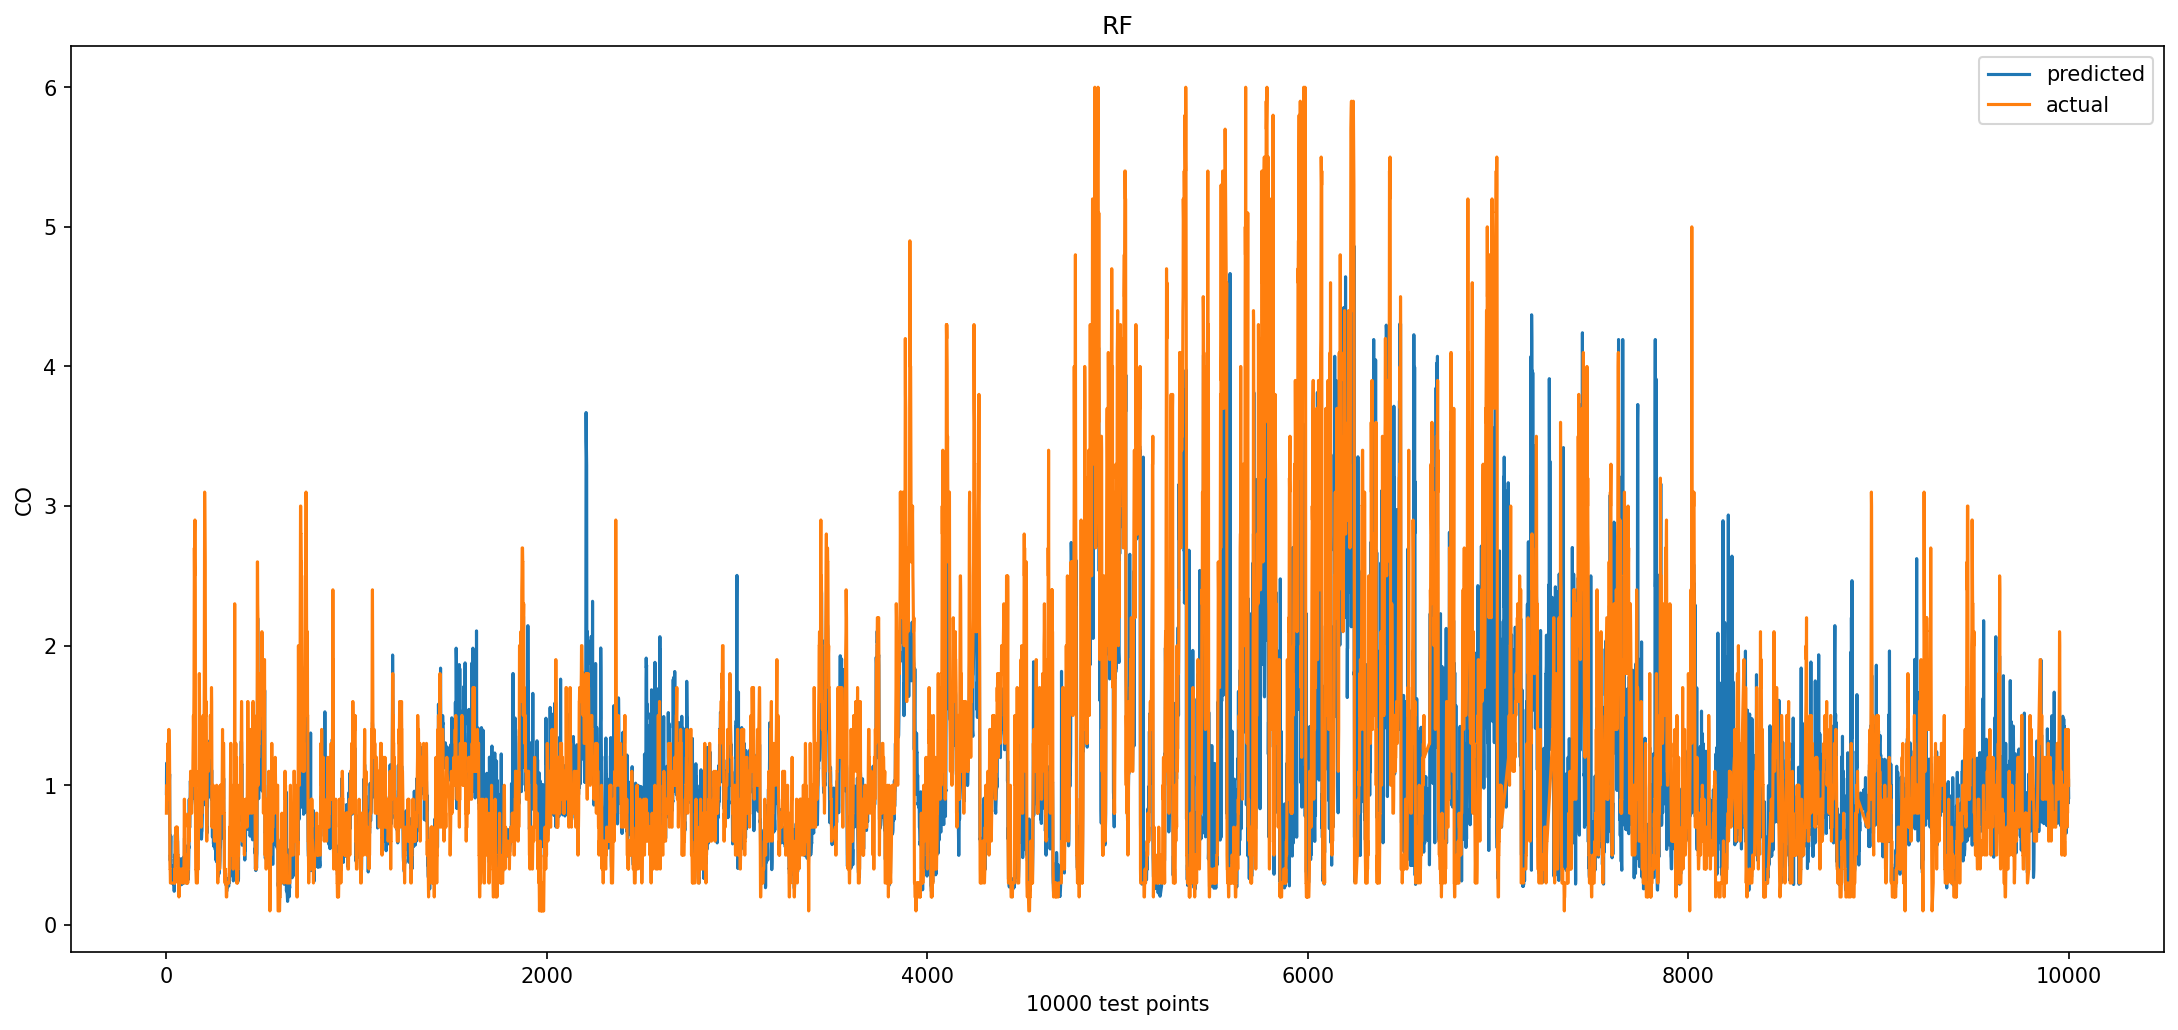

In [33]:
# preds_stds = np.array(std_pred)
# preds_mean = np.array(y_mean)
# lower_line = preds_mean - 2 * preds_stds
# upper_line = preds_mean + 2 * preds_stds

test_points = 10000

test_y1 = np.array(test_output)
# print(preds_mean.shape, preds_stds.shape)

plt.rcParams["figure.dpi"] = 150
fig = plt.figure(figsize=(18, 8))
# plt.fill_between(
#     range(len(test_y1[:test_points])),
#     lower_line[:],
#     upper_line[:],
#     facecolor="gray",
#     alpha=0.5,
#     label=r"95% confidence",
# )
print(0)
plt.plot(scaler_co.inverse_transform(pred_rf.reshape(-1,1)), label=r"predicted", linewidth=1.5)
# y_test = test_y1[:5000,:]
plt.plot(test_y1[:test_points], label=r"actual", linewidth=1.5)
plt.ylabel("CO")
plt.legend()
plt.xlabel("10000 test points")
plt.title(
    "RF"
)

## KNN

In [34]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()
neigh.fit(train_input[:train_points,:], train_output[:train_points])

KNeighborsRegressor()

In [35]:
pred_knn = neigh.predict(test_input[:10000,:])

In [36]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(scaler_co.inverse_transform(pred_knn.reshape(-1,1))) - test_output[:10000]))))

Test MAE: 0.8312609791755676


0


Text(0.5, 1.0, 'KNN')

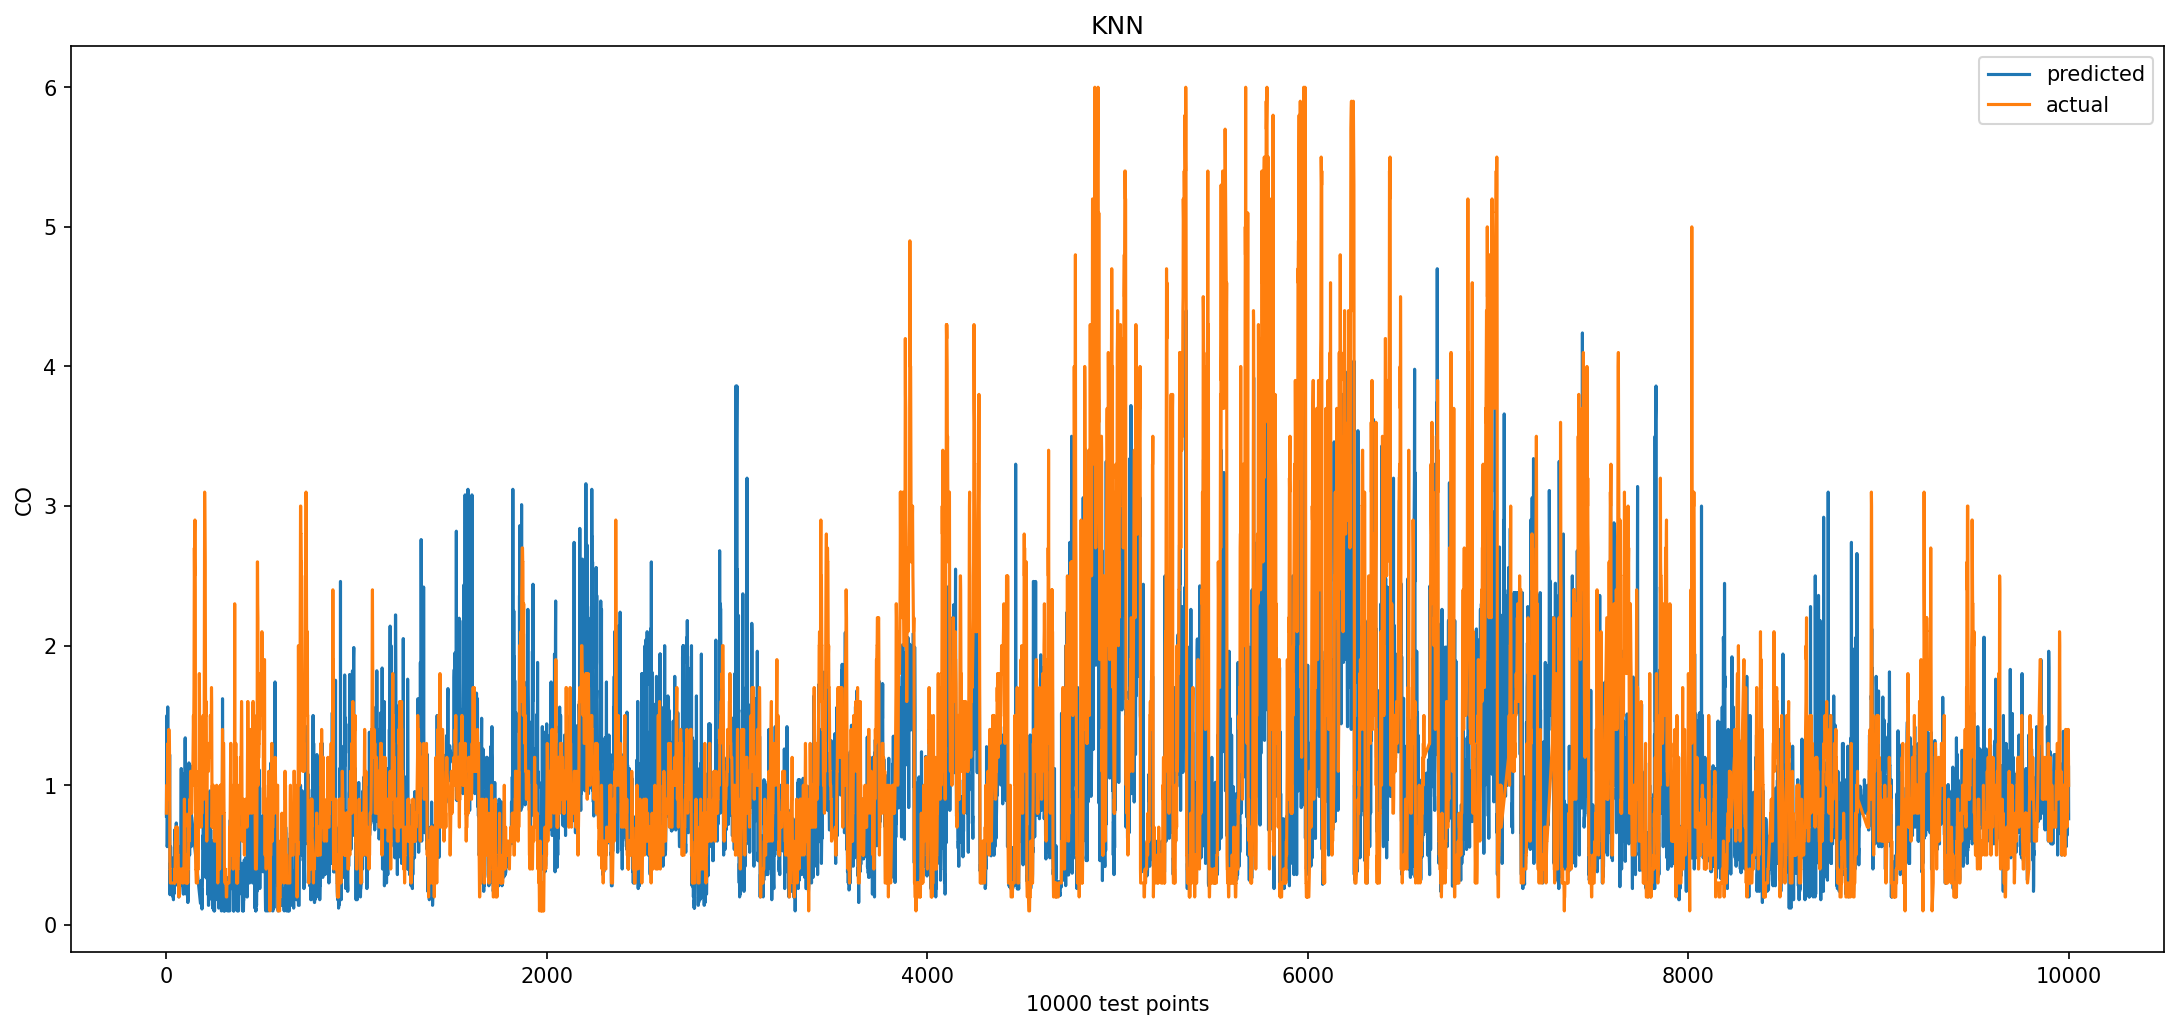

In [38]:
# preds_stds = np.array(std_pred)
# preds_mean = np.array(y_mean)
# lower_line = preds_mean - 2 * preds_stds
# upper_line = preds_mean + 2 * preds_stds

test_points = 10000

test_y1 = np.array(test_output)
# print(preds_mean.shape, preds_stds.shape)

plt.rcParams["figure.dpi"] = 150
fig = plt.figure(figsize=(18, 8))
# plt.fill_between(
#     range(len(test_y1[:test_points])),
#     lower_line[:],
#     upper_line[:],
#     facecolor="gray",
#     alpha=0.5,
#     label=r"95% confidence",
# )
print(0)
plt.plot(scaler_co.inverse_transform(pred_knn.reshape(-1,1)), label=r"predicted", linewidth=1.5)
# y_test = test_y1[:5000,:]
plt.plot(test_y1[:test_points], label=r"actual", linewidth=1.5)
plt.ylabel("CO")
plt.legend()
plt.xlabel("10000 test points")
plt.title(
    "KNN"
)

## linear_reg

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
reg = LinearRegression().fit(train_input[:train_points,:], train_output[:train_points])

In [41]:
pred_lr = reg.predict(test_input[:10000,:])

In [42]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(scaler_co.inverse_transform(pred_lr.reshape(-1,1))) - test_output[:10000]))))

Test MAE: 0.7600681781768799


0


Text(0.5, 1.0, 'lr')

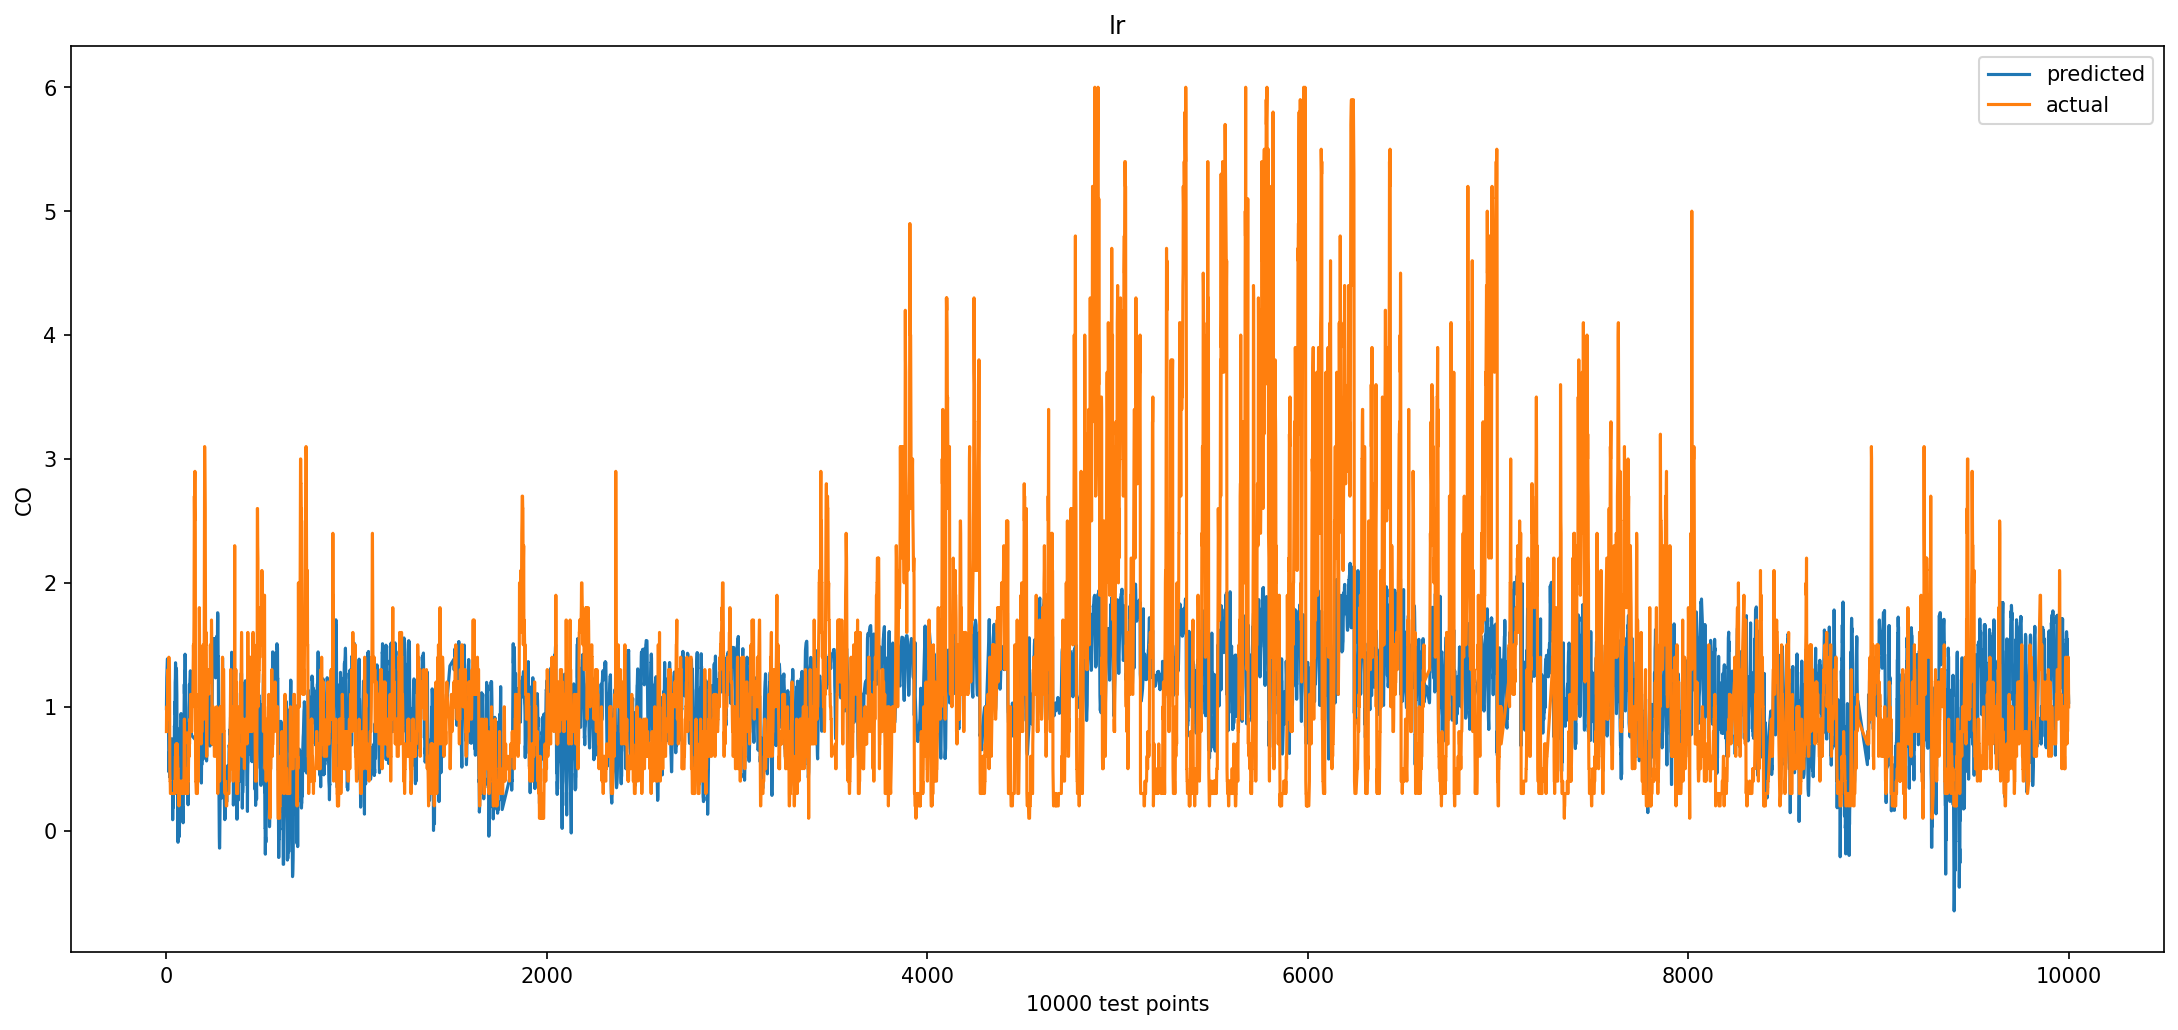

In [43]:
# preds_stds = np.array(std_pred)
# preds_mean = np.array(y_mean)
# lower_line = preds_mean - 2 * preds_stds
# upper_line = preds_mean + 2 * preds_stds

test_points = 10000

test_y1 = np.array(test_output)
# print(preds_mean.shape, preds_stds.shape)

plt.rcParams["figure.dpi"] = 150
fig = plt.figure(figsize=(18, 8))
# plt.fill_between(
#     range(len(test_y1[:test_points])),
#     lower_line[:],
#     upper_line[:],
#     facecolor="gray",
#     alpha=0.5,
#     label=r"95% confidence",
# )
print(0)
plt.plot(scaler_co.inverse_transform(pred_lr.reshape(-1,1)), label=r"predicted", linewidth=1.5)
# y_test = test_y1[:5000,:]
plt.plot(test_y1[:test_points], label=r"actual", linewidth=1.5)
plt.ylabel("CO")
plt.legend()
plt.xlabel("10000 test points")
plt.title(
    "lr"
)